# Download Dataset

In [ ]:
# %pip install -q kaggle

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download -d athota1/caltech101

In [ ]:
# ! ls

In [ ]:
# !mkdir caltech_101_plots
# !mkdir caltech_101_models

In [ ]:
# !unzip caltech101.zip 
# !mkdir 101_ObjectCategories

# !tar -xvf 101_ObjectCategories.tar.gz

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import time
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from imutils import paths

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
torch.backends.cudnn.benchmark = True

# EDA

In [ ]:
image_paths = list(paths.list_images('./101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print("Percentage of each class: ")
dict(zip(unique, (counts*100/len(labels))))

Percentage of each class: 


{'Faces': 5.013253428604356,
 'Faces_easy': 5.013253428604356,
 'Leopards': 2.3049441051054513,
 'Motorbikes': 9.19672697937075,
 'accordion': 0.633859628903999,
 'airplanes': 9.219776420421805,
 'anchor': 0.48403826207214473,
 'ant': 0.48403826207214473,
 'barrel': 0.5416618646997811,
 'bass': 0.6223349083784718,
 'beaver': 0.5301371441742537,
 'binocular': 0.38031577734239946,
 'bonsai': 1.4751642272674887,
 'brain': 1.129422611501671,
 'brontosaurus': 0.495562982597672,
 'buddha': 0.9796012446698168,
 'butterfly': 1.0487495678229803,
 'camera': 0.5762360262763628,
 'cannon': 0.495562982597672,
 'car_side': 1.4175406246398525,
 'ceiling_fan': 0.5416618646997811,
 'cellphone': 0.6799585110061082,
 'chair': 0.7145326725826898,
 'chandelier': 1.2331450962314163,
 'cougar_body': 0.5416618646997811,
 'cougar_face': 0.7952057162613807,
 'crab': 0.8413045983634897,
 'crayfish': 0.8067304367869079,
 'crocodile': 0.5762360262763628,
 'crocodile_head': 0.58776074680189,
 'cup': 0.6569090699550

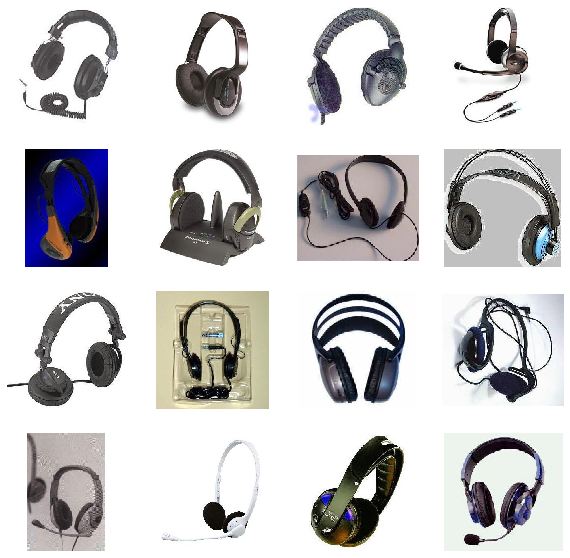

In [ ]:
imgs = data[labels == 'headphone']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
    image = imgs[i]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(image)

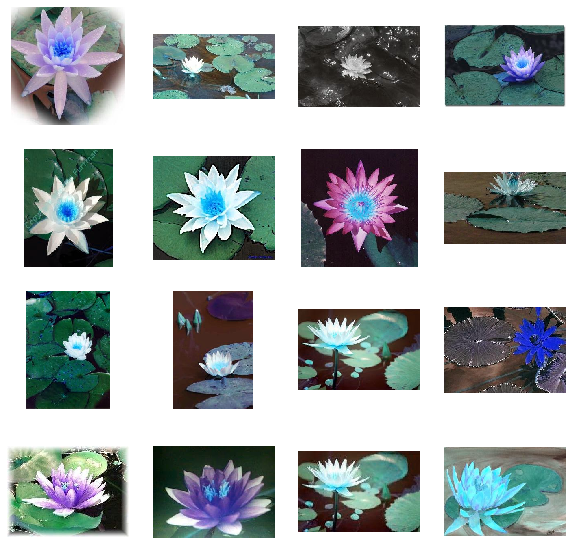

In [ ]:
imgs = data[labels == 'water_lilly']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
    image = imgs[i]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(image)

# Image Recognition



In [ ]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)

In [ ]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [ ]:
(X, x_val , Y, y_val) = train_test_split(data, targets, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5552,)
x_test examples: (1389,)
x_val examples: (1736,)


In [ ]:
BATCH_SIZE = 40
epochs = 10

In [ ]:
def save_checkpoint(state):
    torch.save(state, 'caltech_101_models/model.pth')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        


In [ ]:
train_data = ImageDataset(x_train, y_train, transform)
val_data = ImageDataset(x_val, y_val, transform)
test_data = ImageDataset(x_test, y_test, transform)

In [ ]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = nn.DataParallel(models.resnet50(pretrained=True))
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, 101))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [ ]:
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [ ]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct, total

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
acc_max = 0
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    if(acc_max<val_epoch_accuracy):
      print("Validation accuracy increased, saving the model")
      save_checkpoint({'model': model.state_dict()})
      acc_max = val_epoch_accuracy

end = time.time()
print((end-start)/60, 'minutes')


  0%|          | 0/138 [00:00<?, ?it/s]

Training on 5552 examples, validating on 1736 examples...
Epoch 1 of 10
Training


139it [00:54,  2.55it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0533, Train Acc: 62.55
Validating


44it [00:10,  4.34it/s]                        


Val Loss: 0.0110, Val Acc: 88.59
Validation accuracy increased, saving the model


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2 of 10
Training


139it [00:44,  3.10it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0060, Train Acc: 94.97
Validating


44it [00:09,  4.60it/s]                        


Val Loss: 0.0063, Val Acc: 93.61
Validation accuracy increased, saving the model


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3 of 10
Training


139it [00:44,  3.12it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 98.78
Validating


44it [00:09,  4.66it/s]                        


Val Loss: 0.0048, Val Acc: 94.59
Validation accuracy increased, saving the model


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4 of 10
Training


139it [00:44,  3.10it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 99.35
Validating


44it [00:09,  4.44it/s]                        


Val Loss: 0.0049, Val Acc: 94.82
Validation accuracy increased, saving the model


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 5 of 10
Training


139it [00:44,  3.12it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 99.66
Validating


44it [00:09,  4.46it/s]                        


Val Loss: 0.0050, Val Acc: 95.45
Validation accuracy increased, saving the model


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 6 of 10
Training


139it [00:44,  3.11it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 99.69
Validating


44it [00:09,  4.59it/s]                        
  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss: 0.0055, Val Acc: 94.24
Epoch 7 of 10
Training


139it [00:44,  3.16it/s]                         
  2%|▏         | 1/43 [00:00<00:08,  5.06it/s]

Train Loss: 0.0007, Train Acc: 99.48
Validating


44it [00:09,  4.60it/s]                        
  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss: 0.0055, Val Acc: 94.53
Epoch 8 of 10
Training


139it [00:44,  3.10it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.28
Validating


44it [00:09,  4.67it/s]                        
  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss: 0.0065, Val Acc: 94.35
Epoch 9 of 10
Training


139it [00:44,  3.10it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 99.17
Validating


44it [00:09,  4.49it/s]                        
  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss: 0.0069, Val Acc: 93.38
Epoch 10 of 10
Training


139it [00:44,  3.15it/s]                         
  0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.33
Validating


44it [00:09,  4.68it/s]                        

Val Loss: 0.0058, Val Acc: 94.87
9.309826223055522 minutes


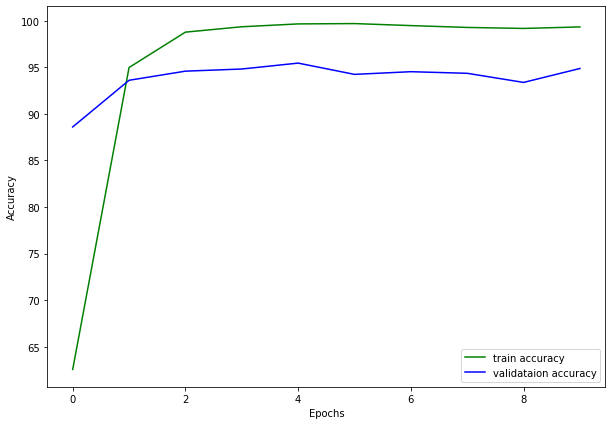

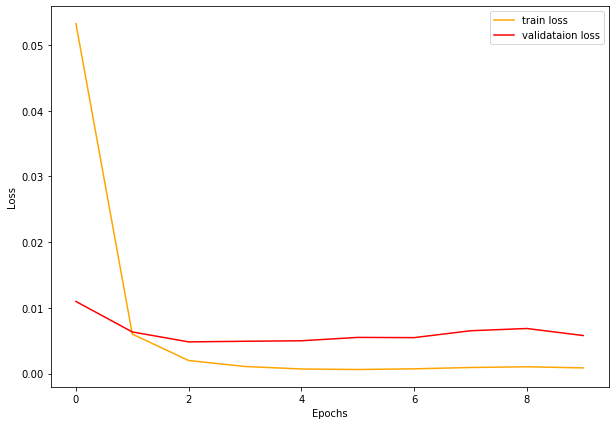

In [ ]:

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./caltech_101_plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./caltech_101_plots/loss.png')

In [ ]:
best_model = torch.load("./caltech_101_models/model.pth")
print(best_model.keys())
model.load_state_dict(best_model['model'])
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('finished running')

dict_keys(['model'])
Accuracy of the network on test images: 95.752 %
finished running
